In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

sns.set_style('whitegrid')

In [46]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, precision_score, f1_score, roc_curve

- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f
- https://docs.aws.amazon.com/pt_br/machine-learning/latest/dg/cross-validation.html

In [47]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_combine = pd.concat([df_train, df_test])#, axis = 1)

| Variable |      Definition      |       Key       |
|----------|:--------------------:|----------------:|
| survival |  Survival            | 0 = No, 1 = Yes |
| sex      |	Sex	| |
| Age |	Age in years	| |
| sibsp |	# of siblings / spouses aboard the Titanic	| |
| parch |	# of parents / children aboard the Titanic	| |
| ticket |	Ticket number	| |
| fare |	Passenger fare	| |
| cabin |	Cabin number	| |
| embarked |	Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton|

In [48]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [50]:
df_combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [51]:
df_combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

# Survived

In [52]:
print("% of who survived:", round(df_combine['Survived'].mean() * 100, 2), "%")
print("% of who not survived:",round((1 - df_combine['Survived'].mean()) * 100, 2), "%")

% of who survived: 38.38 %
% of who not survived: 61.62 %


### Class survived

In [53]:
df_combine[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Sex survived

In [54]:
df_combine[["Sex", "Survived"]].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


### Sibling and Spouse  survived

In [55]:
df_combine[["SibSp", "Survived"]].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


## FamilySize 

In [56]:
df_combine[["Parch", "Survived"]].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000
9,NaN


In [57]:
df_combine['FamilySize'] = df_combine['SibSp'] + df_combine['Parch'] + 1

df_combine[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


###  Parent and Child survived

In [58]:
df_combine['IsAlone'] = 0
df_combine.loc[df_combine['FamilySize'] == 1, 'IsAlone'] = 1

df_combine[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


### Filter Embarked


In [59]:
# Calcula o porto mais frequente
freq_port = df_combine['Embarked'].dropna().mode()[0]

# Preenche NaNs com o porto mais frequente
df_combine['Embarked'] = df_combine['Embarked'].fillna(freq_port)

# Seu código original
df_combine[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Conclusion
Only 38% survived the crash. In this way we must look for correlations between the items we have. Analyze by pivoting features:
- **Sex:** Women make up 35% of the crew. Even with a smaller presence, 74% of them survived;
- **Pclass:** There is a correlation between the survivors, with the classification of their cabins;
- **SibSp and Parch:** These features have zero correlation. It will be necessary to change the data

## Plot for Age

<Figure size 2000x1000 with 0 Axes>

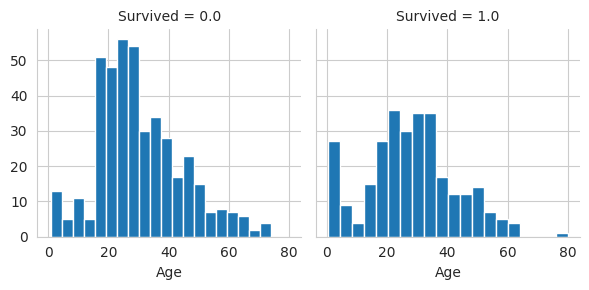

In [60]:
plt.figure(figsize=(20,10))
g = sns.FacetGrid(df_combine, col='Survived')
g.map(plt.hist, 'Age', bins=20)


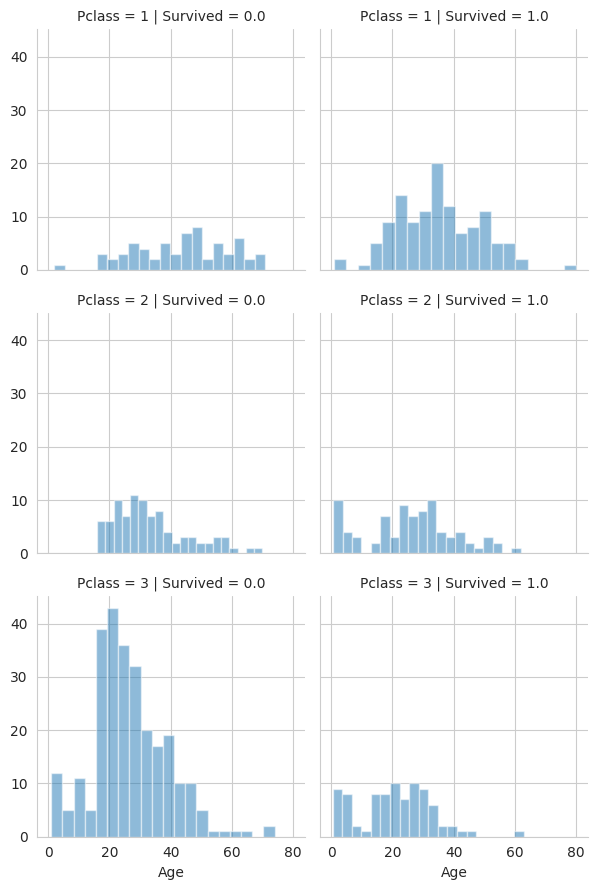

In [61]:
grid = sns.FacetGrid(df_combine, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

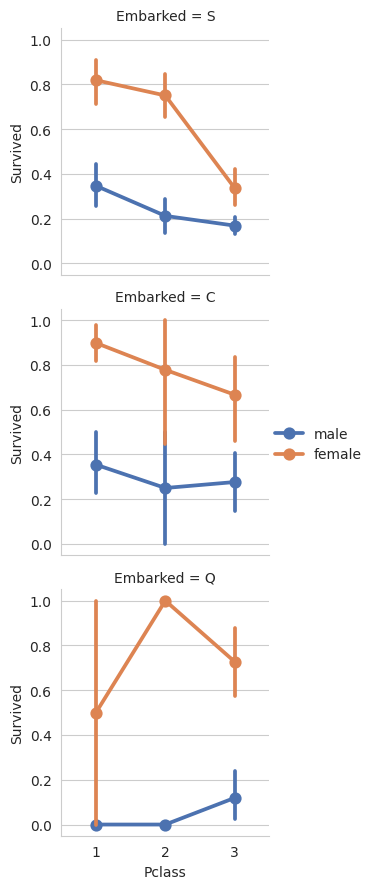

In [62]:
# Determine a order and hue_order based on your data
pclass_order = sorted(df_combine['Pclass'].unique())
sex_order = ['male', 'female']  # or ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=pclass_order, hue_order=sex_order)
grid.add_legend()

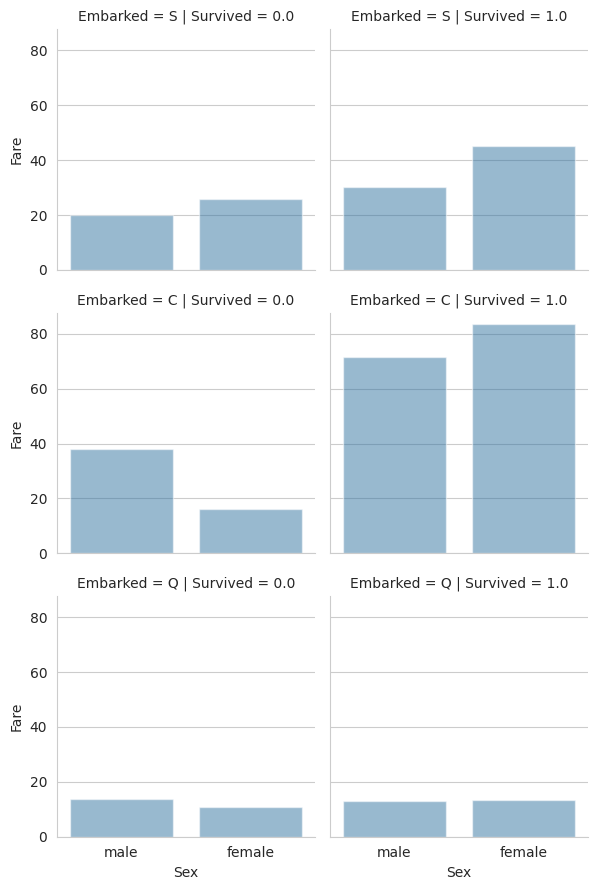

In [63]:
# Determine the order based on your data
sex_order = ['male', 'female']  # Ou ['female', 'male'], dependendo da sua preferência

grid = sns.FacetGrid(df_combine, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None, order=sex_order)
grid.add_legend()

## Filter Title

In [64]:
df_combine['Title'] = df_combine['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [65]:
df_combine['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [66]:
df_combine['Title'] = [n if n in ["Mr", "Miss", "Mrs", "Master"] else 'Person' for n in df_combine['Title']]
df_combine['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Person'], dtype=object)

In [67]:
df_combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr


### Filter Age

In [68]:
df_combine['Age'].fillna(df_combine['Age'].median(), inplace=True)
df_combine['AgeBand'] = pd.cut(df_combine['Age'], 5)
df_combine[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False, observed=True).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.0902, 16.136]",0.550000
1,"(16.136, 32.102]",0.344168
2,"(32.102, 48.068]",0.404255
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [69]:
df_combine.loc[ df_combine['Age'] <= 16, 'Categori_Age'] = 0
df_combine.loc[(df_combine['Age'] > 16) & (df_combine['Age'] <= 32), 'Categori_Age'] = 1
df_combine.loc[(df_combine['Age'] > 32) & (df_combine['Age'] <= 48), 'Categori_Age'] = 2
df_combine.loc[(df_combine['Age'] > 48) & (df_combine['Age'] <= 64), 'Categori_Age'] = 3
df_combine.loc[(df_combine['Age'] >= 64), 'Categori_Age'] = 4

In [70]:
df_combine['Categori_Age'].value_counts()

Categori_Age
1.0    787
2.0    269
0.0    134
3.0    101
4.0     18
Name: count, dtype: int64

In [71]:
df_combine['Age*Class'] = df_combine.Categori_Age * df_combine.Pclass
df_combine.loc[:, ['Age*Class', 'Categori_Age', 'Pclass']].head(10)

,Age*Class,Categori_Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,3.0,1.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


In [72]:
df_combine['FareBand'] = pd.qcut(df_combine['Fare'], 4)
df_combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False, observed=True).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 31.275]",0.441048
3,"(31.275, 512.329]",0.600000


In [73]:
# 1. Preenchendo NaNs
df_combine['Fare'].fillna(df_combine['Fare'].median(), inplace=True)

# 2. Verificando valores infinitos (opcional, mas uma boa prática)
if not np.isfinite(df_combine['Fare']).all():
    # Trate os valores infinitos como você achar melhor. Aqui, estou substituindo-os pela mediana
    median_fare = df_combine['Fare'].median()
    df_combine['Fare'] = df_combine['Fare'].replace([np.inf, -np.inf], median_fare)

# 3. Execute seu código original
df_combine.loc[ df_combine['Fare'] <= 7.91, 'Fare'] = 0
df_combine.loc[(df_combine['Fare'] > 7.91) & (df_combine['Fare'] <= 14.454), 'Fare'] = 1
df_combine.loc[(df_combine['Fare'] > 14.454) & (df_combine['Fare'] <= 31), 'Fare']   = 2
df_combine.loc[ df_combine['Fare'] > 31, 'Fare'] = 3
df_combine['Fare'] = df_combine['Fare'].astype(int)

df_combine = df_combine.drop(['FareBand'], axis=1)

df_combine.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,Title,AgeBand,Categori_Age,Age*Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,NaN,S,2,0,Mr,"(16.136, 32.102]",1.0,3.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,3,C85,C,2,0,Mrs,"(32.102, 48.068]",2.0,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,1,NaN,S,1,1,Miss,"(16.136, 32.102]",1.0,3.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3,C123,S,2,0,Mrs,"(32.102, 48.068]",2.0,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,1,NaN,S,1,1,Mr,"(32.102, 48.068]",2.0,6.0
5,6,0.0,3,"Moran, Mr. James",male,28.0,0,0,330877,1,NaN,Q,1,1,Mr,"(16.136, 32.102]",1.0,3.0
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3,E46,S,1,1,Mr,"(48.068, 64.034]",3.0,3.0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,2,NaN,S,5,0,Master,"(0.0902, 16.136]",0.0,0.0
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,1,NaN,S,3,0,Mrs,"(16.136, 32.102]",1.0,3.0
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,2,NaN,C,2,0,Mrs,"(0.0902, 16.136]",0.0,0.0


### Construct Data test and training

In [74]:
pclass = pd.get_dummies(df_combine['Pclass'], prefix = 'Pclass', drop_first=True)
title = pd.get_dummies(df_combine['Title'], prefix = 'Title', drop_first=True)
sex = pd.get_dummies(df_combine['Sex'], prefix = 'Sex', drop_first=True)
age = pd.get_dummies(df_combine['Age'], prefix = 'Age', drop_first=True)
fare = pd.get_dummies(df_combine['Fare'], prefix = 'Fare', drop_first=True)
embarked = pd.get_dummies(df_combine['Embarked'], prefix = 'Embarked', drop_first=True)
age_class = pd.get_dummies(df_combine['Age*Class'], prefix = 'Age*Class', drop_first=True)

In [75]:
df_concat = pd.concat([df_combine['Survived'], pclass, title, sex, age, fare, embarked], axis=1)

In [76]:
train = df_concat[:len(df_train)].copy()
test = df_concat[(len(df_combine) - len(df_test)):].copy()
df_concat.shape, train.shape, test.shape

((1309, 110), (891, 110), (418, 110))

In [77]:
X_train = train.drop('Survived', axis = 1)
y_train = train['Survived'] 
X_test = test.drop("Survived", axis=1).copy()
# y_test
X_train.shape, y_train.shape, X_test.shape

((891, 109), (891,), (418, 109))

In [78]:
def benchmark_ml(algorithms, X_train, y_train, cross_validation):
    benchmark_ml = []

    for algorithm_name, algorithm in algorithms.items():
        # print(algorithm_name, algorithm)
        model = algorithm.fit(X_train, y_train)
        accuracy = round(model.score(X_train, y_train) * 100, 2)
        
        train_predict = model_selection.cross_val_predict(algorithm, X_train, y_train, cv= cross_validation, n_jobs = -1)
        accuracy_cross_validation = round(accuracy_score(y_train, train_predict) * 100, 2)
        recall_score_cross_validation = round(recall_score(y_train, train_predict) * 100, 2)
        confusion_matrix_cross_validation = confusion_matrix(y_train, train_predict)
        precision_score_cross_validation = round(precision_score(y_train, train_predict) * 100, 2)
        f1_score_cross_validation = round(f1_score(y_train, train_predict) * 100, 2)
        # roc_curve_cross_validation = roc_curve(y_train, train_predict)
        
        benchmark_ml.append({'algorithm': algorithm_name,
                             'accuracy (%)': accuracy,
                             'accuracy_cross_validation (%)': accuracy_cross_validation,
                             'recall_score' : recall_score_cross_validation,
                             'precision_score' : precision_score_cross_validation,
                             'f1_score' : f1_score_cross_validation,
                             'confusion_matrix' : confusion_matrix_cross_validation,
                            #  'roc_curve' : roc_curve_cross_validation,
                             
                             })
    df_benchmark = pd.DataFrame(benchmark_ml)
    return df_benchmark.sort_values('accuracy_cross_validation (%)', ascending=False)

In [79]:
algorithms = {'Random Forest' : RandomForestClassifier(n_estimators=100), 
              'Logistic Regression' : LogisticRegression(max_iter = 1000), 
              'k-nearest neighbors' : KNeighborsClassifier(n_neighbors = 3), 
              'Linear SVC' : LinearSVC(dual = False),
              'Stochastic Gradient Decent' : SGDClassifier(), 
              'Decision Tree' : DecisionTreeClassifier(),
              'Gradient Boosting' : GradientBoostingClassifier(),
              'Support Vector Machines(SVC)' : SVC(), 
              'Perceptron' : Perceptron(),
              }

cross_validation = 10

In [80]:
result = benchmark_ml(algorithms, X_train, y_train, cross_validation)
result

,algorithm,accuracy (%),accuracy_cross_validation (%),recall_score,precision_score,f1_score,confusion_matrix
7,Support Vector Machines(SVC),85.75,81.93,64.62,84.67,73.30,"[[509, 40], [121, 221]]"
0,Random Forest,93.83,81.71,70.18,79.73,74.65,"[[488, 61], [102, 240]]"
6,Gradient Boosting,86.98,81.48,66.37,81.95,73.34,"[[499, 50], [115, 227]]"
1,Logistic Regression,83.50,81.37,71.35,78.21,74.62,"[[481, 68], [98, 244]]"
3,Linear SVC,84.40,80.92,73.39,76.06,74.70,"[[470, 79], [91, 251]]"
5,Decision Tree,93.83,80.81,71.05,77.14,73.97,"[[477, 72], [99, 243]]"
4,Stochastic Gradient Decent,81.59,76.99,62.28,73.70,67.51,"[[473, 76], [129, 213]]"
2,k-nearest neighbors,85.86,75.08,66.37,67.96,67.16,"[[442, 107], [115, 227]]"
8,Perceptron,79.24,72.28,65.50,63.46,64.46,"[[420, 129], [118, 224]]"


In [81]:
parameters_gbc = dict(max_depth = [n for n in range(1, 5)],
                      min_samples_split = [n for n in range(2, 6)],
                      min_samples_leaf = [n for n in range(2, 6)],
                      n_estimators = [n for n in range(10, 50, 10)],
                      )

cross_validation = 10

In [82]:
best_algorithm = algorithms[result.iloc[0]['algorithm']]

In [83]:
cross_validation = GridSearchCV(estimator = best_algorithm, param_grid = parameters_gbc, cv = cross_validation)

In [84]:
cross_validation.fit(X_train, y_train)

ValueError: Invalid parameter 'max_depth' for estimator SVC(). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [ ]:
# accuracy         
round(cross_validation.best_score_ * 100, 4)

82.9426

In [ ]:
# #best parameters
cross_validation.best_estimator_

GradientBoostingClassifier(max_depth=4, min_samples_leaf=3, n_estimators=40)

In [ ]:
best_algorithm_predict = cross_validation.predict(X_test)

In [ ]:
solution = pd.DataFrame({'PassengerId' : df_test['PassengerId'], 
                         'Survived' : best_algorithm_predict.astype(int)})

solution.to_csv('data/solution.csv', index = False)